In [1]:
import os
import sys
import warnings; warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd

%matplotlib inline

# feature_importance_
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [2]:
# добавляем в sys.path директорию со скриптами
src_dir = os.path.join(os.getcwd(), '..', 'ocp')
sys.path.append(src_dir)

In [3]:
# загружаем необходимые скрипты
from data.loading import load_raw_data
from features.feature_selection import UsefullFeatureSelector, correct_features_lists
from features.feature_engineering import count_row_nans
from features.stats import symmetrical_corrmat, get_top_abs_correlations
from plotting import plot_barplot, plot_missing_matrix

%load_ext autoreload
%autoreload

# задаем константы
SEED = 26

In [4]:
train, test, numerical, categorical = load_raw_data('../data/raw')

# Отбор признаков

## Однозначно бесполезные признаки

Удалим сразу константные признаки, признаки, состоящие только из уникальных значений, а также признаки, полностью состоящие из пропусков.

In [5]:
# используем для этого собственный класс UsefullFeatureSelector
# принимающий два порога (оба по умолчанию равны 1), представляющие
# долю пропусков в признаке и долю самого частого значения признака,  
# соответственно, по которым отбираются признаки
selector = UsefullFeatureSelector()
train = selector.fit_transform(train)
test = selector.transform(test)

NaNs features were found: 18
Constant features were found: 5
ID features were found: 0
Columns to drop: 23


In [6]:
# скорректируем имеющиеся списки числовых и категориальных признаков
numerical, categorical = correct_features_lists(train.columns, numerical, categorical)

After correction: numerical - 173 , categorical: -  34 



## Пропуски

Далее необходимо посмотрим ближе на то, как именно пропуски распределены внутри данных.

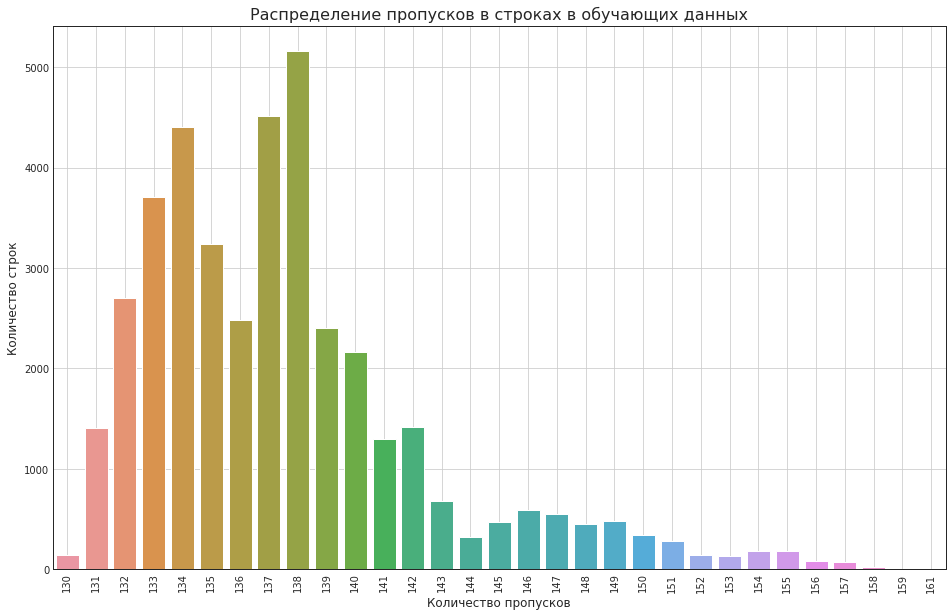

In [7]:
# посчитаем число пропусков в каждой строке и отрисуем 
# график распределения данного числа для данных обучения
nans_train_stats = count_row_nans(train).value_counts().sort_index()
plot_barplot(x=nans_train_stats.index, y=nans_train_stats,
             title='Распределение пропусков в строках в обучающих данных',
             xlabel='Количество пропусков', ylabel='Количество строк',
             xticks_size=10, xlabel_size=12, ylabel_size=12)

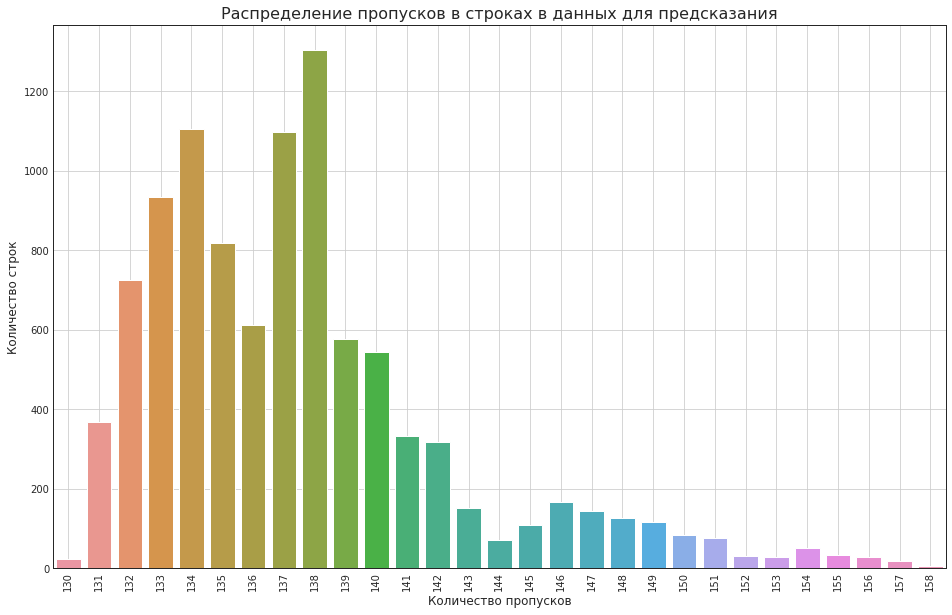

In [8]:
# то же самое сделаем для тестовых данных
nans_test_stats = count_row_nans(test).value_counts().sort_index()
plot_barplot(x=nans_test_stats.index, y=nans_test_stats,
             title='Распределение пропусков в строках в данных для предсказания',
             xlabel='Количество пропусков', ylabel='Количество строк',
             xticks_size=10, xlabel_size=12, ylabel_size=12)

Мы видим, что распределения пропусков для трейна и теста практически идентичны друг другу, при чем минимальное количество пропусков в строке равно 130.

Далее посмотрим на то, в каких местах (признаках) строк чаще всего встречаются пропуски, попробуем таким образом понять паттерн возникновения пропусков.

In [9]:
# добавим к трейну признак - количество пропусков в строках
train['nans'] = count_row_nans(train)
test['nans'] = count_row_nans(test)

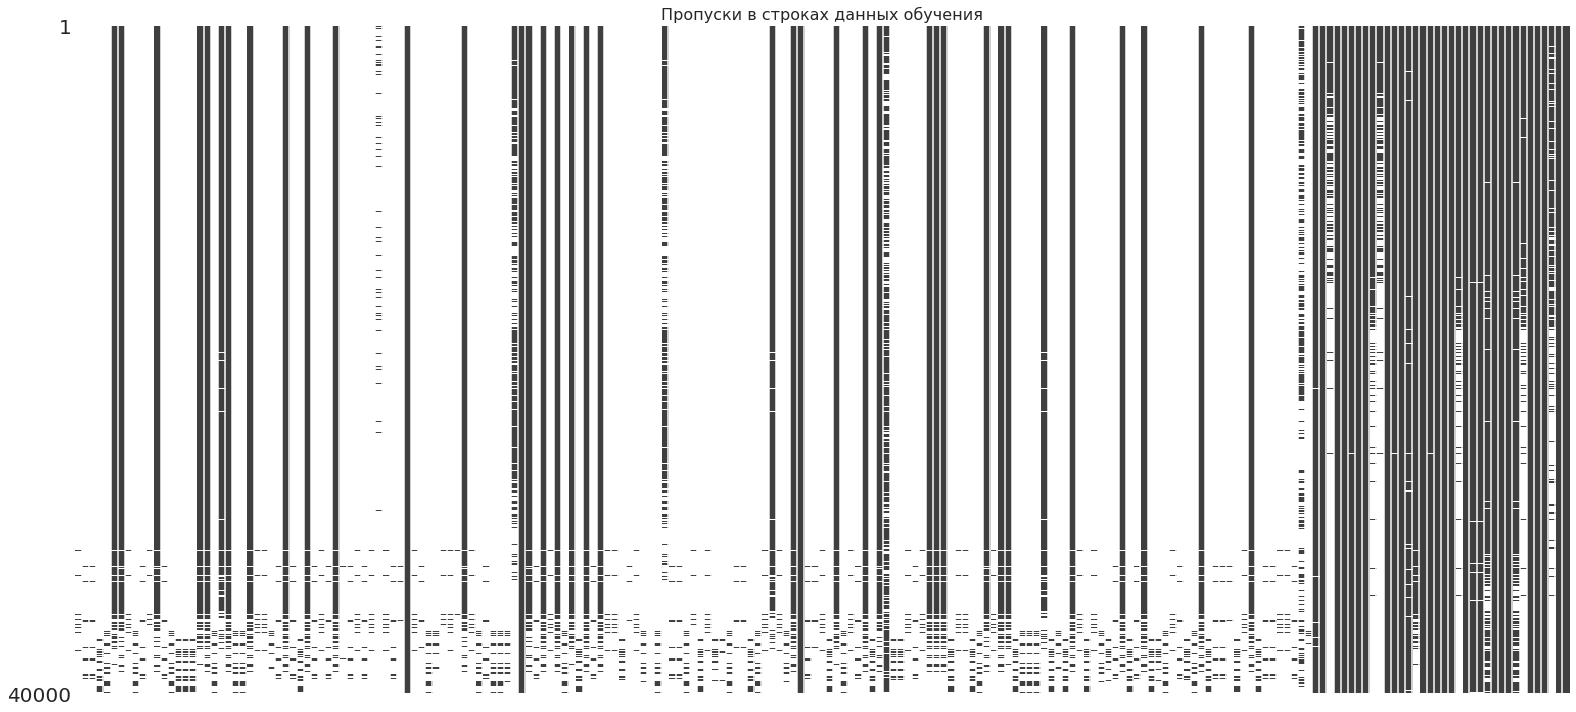

In [10]:
# воспользуемся функцией matrix библиотеки missingno
# для построения необходимого графического представления,
# строки в данных отсортируем по количеству пропусков в них

plot_missing_matrix(data=train.sort_values('nans'),
                    title='Пропуски в строках данных обучения')

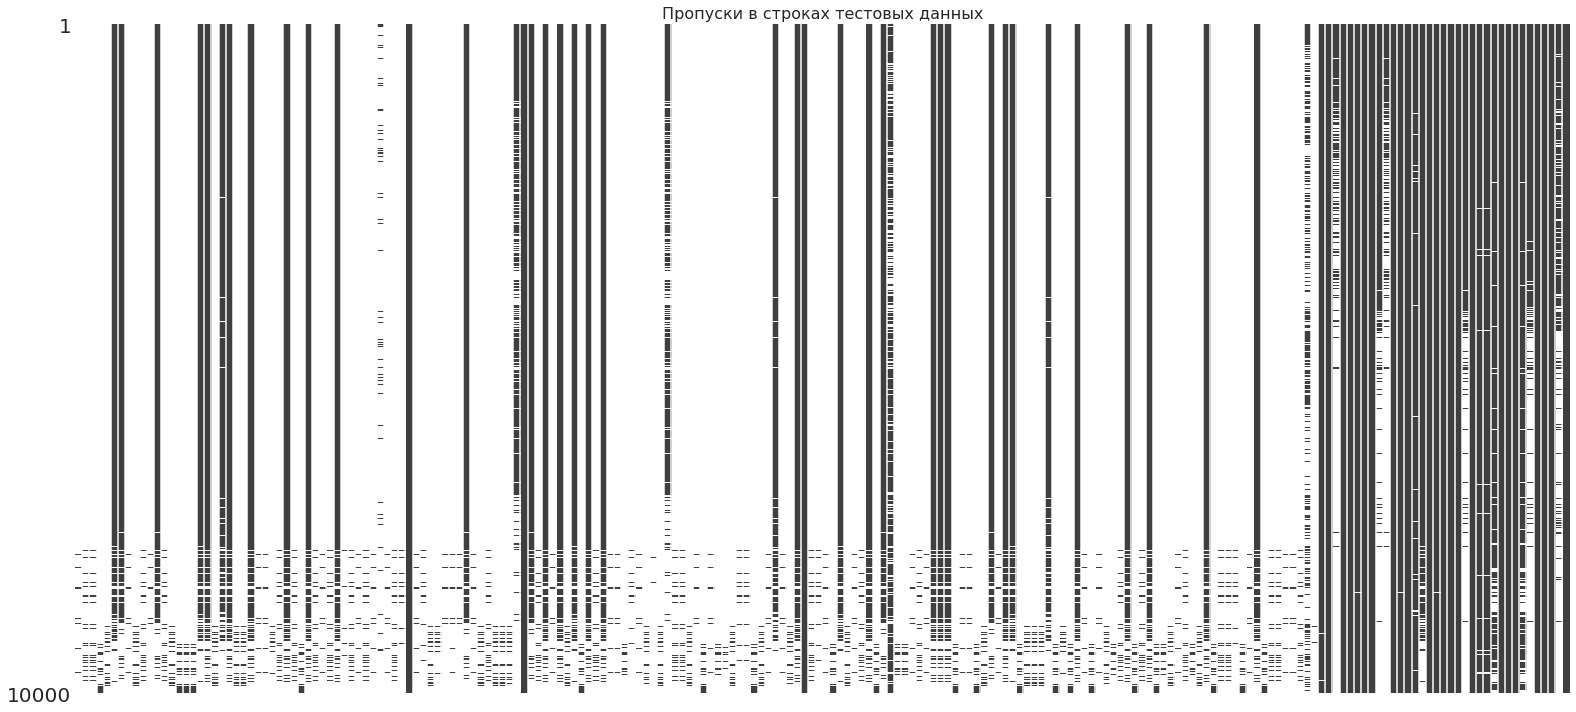

In [11]:
# посмотрим таким же образом на тестовые данные
plot_missing_matrix(data=test.sort_values('nans'),
                    title='Пропуски в строках тестовых данных')

Из полученных визуализаций видно, что в группе с наименьшим числом пропусков (130) все пропуски находятся в определенном подмножестве признаков. Обозначим его за подмножество B, заполненные признаки обозначим за подмножество A, а в сумме они будут давать множество всех имеющихся признаков C. 

Дальнейшее увеличение числа пропусков в строках до определенного момента происходит только за счет появления пропусков в признаках подмножества A. Однако с какого-то момента появляются строки, структура пропусков в которых начинает сильно отличаться от рассмотренной ранее. Значения некоторых признаков  подмножества B, ранее пустых, оказываются заполненными, в то время как некоторые признаки из подмножества А оказываются полностью пустыми.

Для того, чтобы убедиться в этом, отдельно выделим признаки подмножества А и повторим построение визуализаций, предварительно отсортировав трейн и тест по признакам подмножества А.

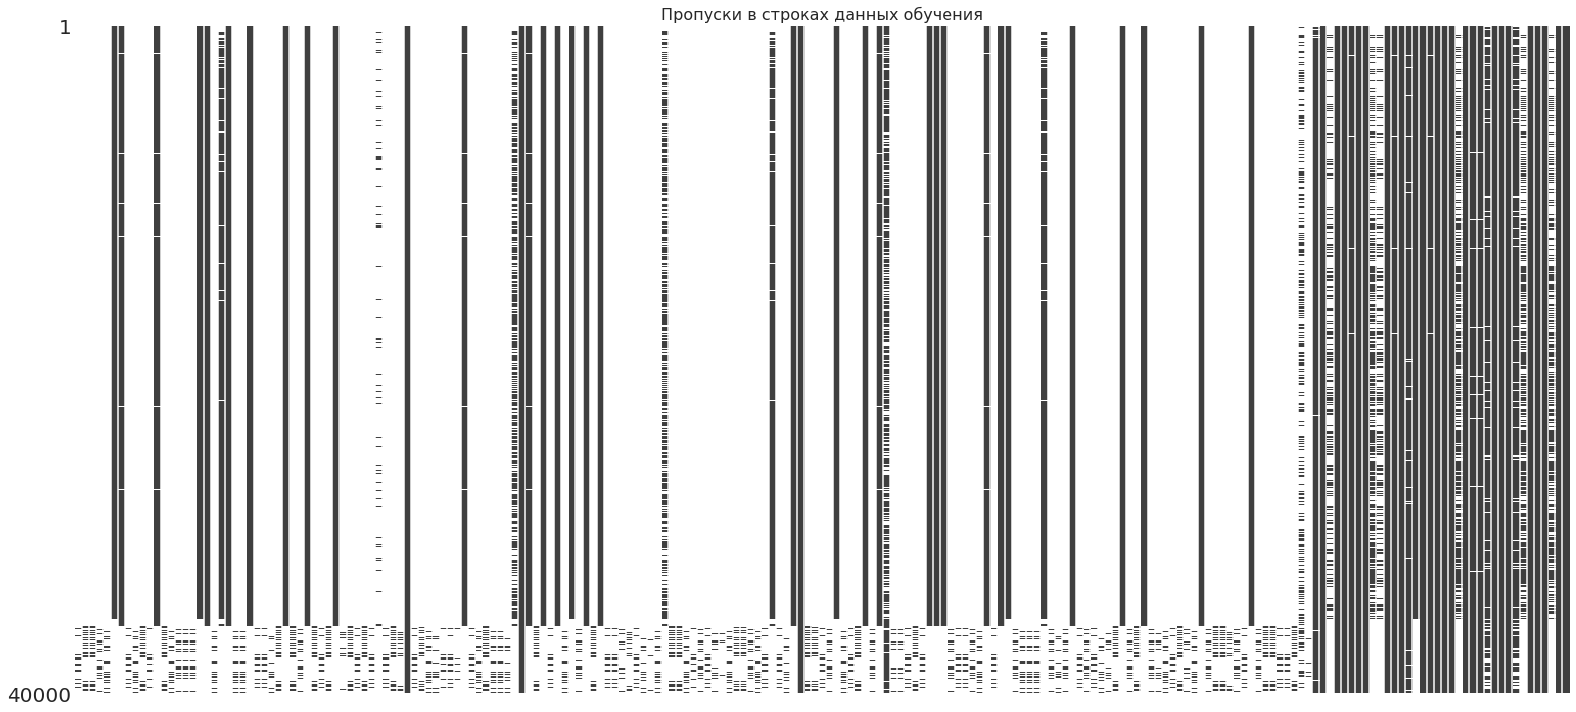

In [12]:
# выделяем признаки
columns = (train
           .query('nans == 130')
           .drop(['nans'], axis=1)
           .dropna(how='all', axis=1).columns.to_list())

# повторяем операцию
# для трейна
plot_missing_matrix(data=train.sort_values(columns),
                    title='Пропуски в строках данных обучения')

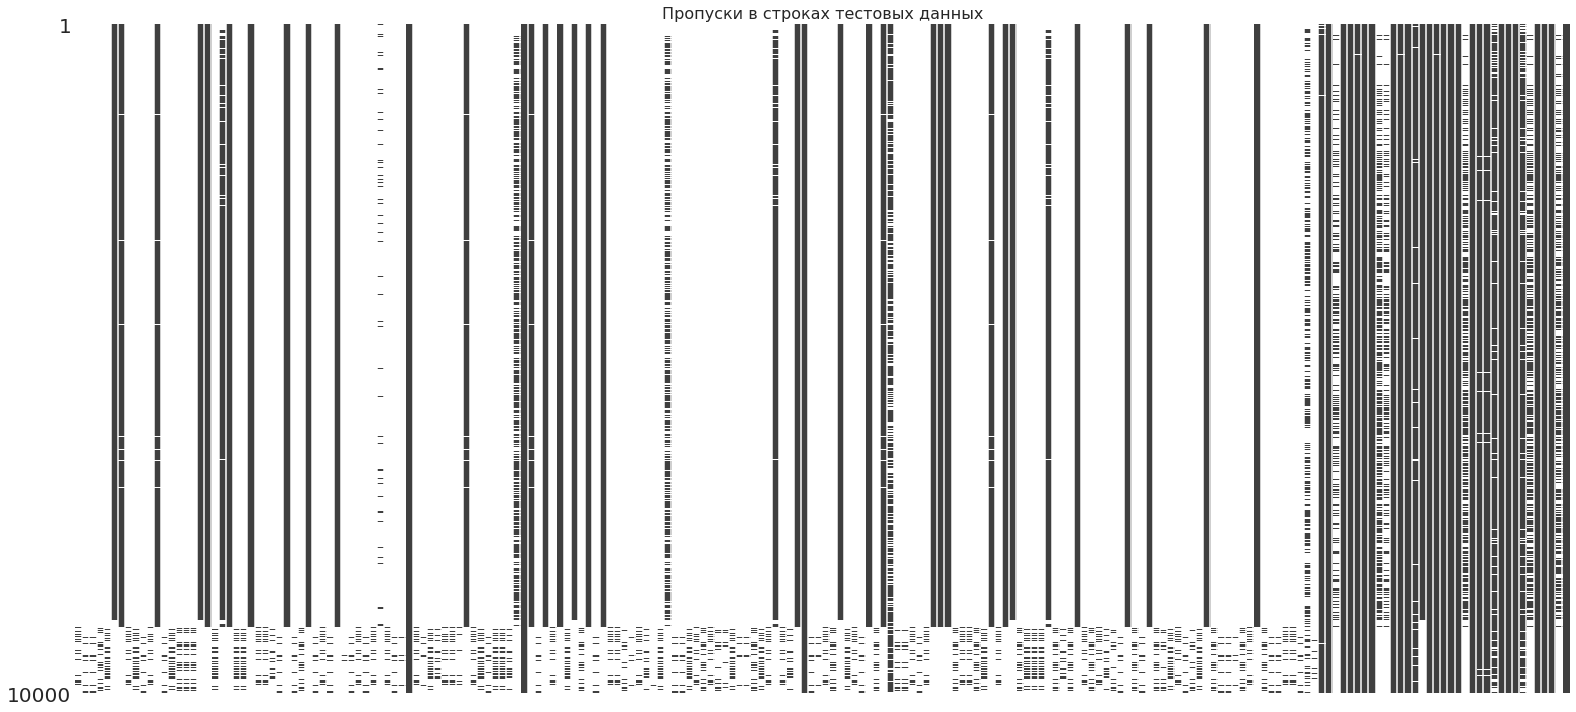

In [ ]:
plot_missing_matrix(data=test.sort_values(columns),
                    title='Пропуски в строках тестовых данных')

По полученных визуализациям становится ясно следующее (для удобства условно разделим строки на принадлежность к меньшей и большей группам):

1. В большей группе (~90% всех строк) признаки подмножества В состоят полностью из пропусков (как в трейне, так и в тесте);

2. В меньшей группе строк большинство признаков подмножества А становятся полностью пустыми, а признаки подмножества В заполнены лишь частично (как в трейне, так и в тесте);

Вывод, который я делаю исходя из этих пунктов такой, что в данных следует оставить только признаки подмножества А, сократив размер признакового пространства сразу в несколько раз. При таком подходе строки из меньшей части будут иметь пропуски в значительной части оставшихся признаков, следует это учесть при валидации модели и делить данные так, чтобы пропорции строк из большей и меньшей частей были одинаковы в каждом из разбиений.



In [14]:
# оставляем только признаки подмножества А
train = train[columns]
test = test[columns[:-1]]

# корректируем списки переменных
numerical, categorical = correct_features_lists(train.columns, numerical, categorical)

After correction: numerical - 43 , categorical: -  34 



Посмотрим на структуру пропусков после удаления признаков подмножества B.

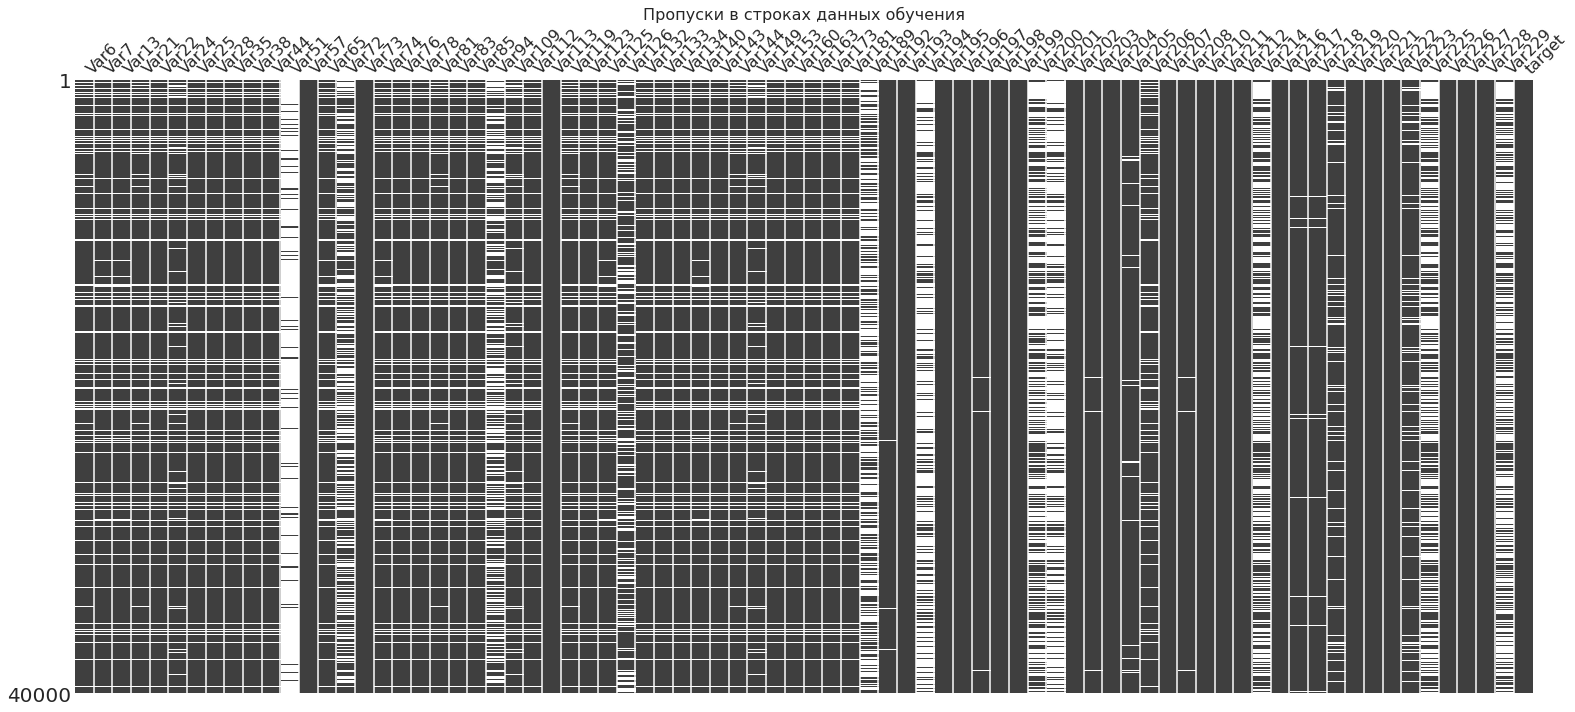

In [ ]:
plot_missing_matrix(data=train, labels=True,
                    title='Пропуски в строках данных обучения')

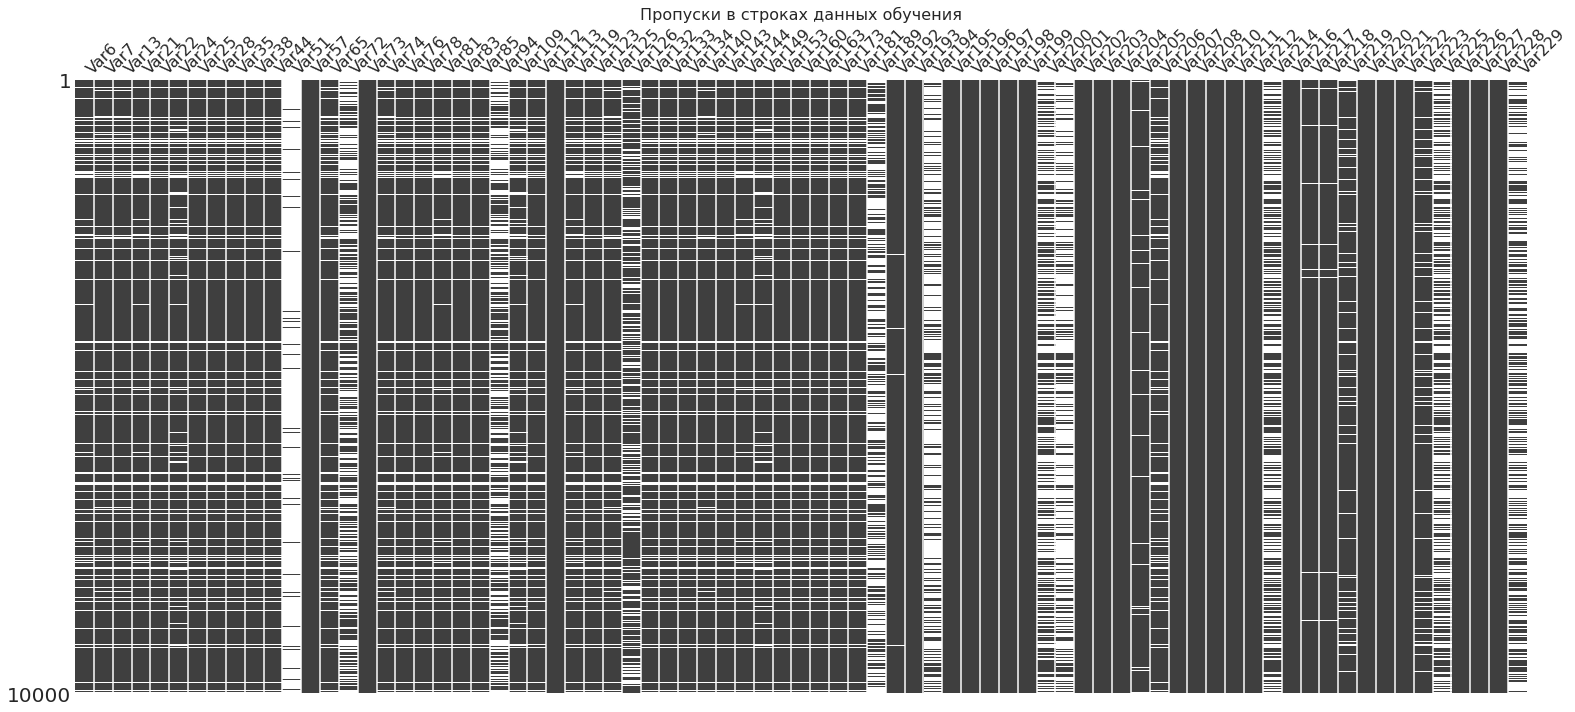

In [ ]:
plot_missing_matrix(data=test, labels=True,
                    title='Пропуски в строках данных обучения')

Создадим список признаков columns_to_drop, которые в дальнейшем будут удалены из данных и добавим в него практически пустой признак Var51.

In [15]:
columns_to_drop = ['Var51']

## Полностью связанные друг с другом признаки

Далее исследуем наличие связанных друг с другом признаков. Начнем с категориальных.

Так как данные анонимизированы, то простое сравнение двух категориальных признаков на идентичность не имеет особого смысла, т.к. переменные могут полностью совпадать, но уровни категориальных переменных могут быть закодированы совершенно по-разному. Для проверки идентичности двух категориальных переменных я воспользуюсь симметричной версией коэффициента неопределенности, который равен 1 только в том случае если с помощью одного признака можно полностью предсказать другой, и наоборот.

In [ ]:
# создадим матрицу, заполненную симметричной версией коэффициента неопределенности
# и с помощью функции get_top_abs_correlations выведем все пары,
# симметричный коэффициент неопределенности для которых равен 1.
corrmat = symmetrical_corrmat(train[categorical], coef='theilsu')
print(get_top_abs_correlations(corrmat, 1))

Var198  Var222    1.0
Var200  Var214    1.0
Var198  Var220    1.0
Var220  Var222    1.0
dtype: float32


In [18]:
# из полученных результатов выберем те признаки,
# которые необходимо будет удалить и добавим их в columns_to_drop
columns_to_drop += ['Var214', 'Var222', 'Var220']

Для числовых переменных оценим их степень взаимосвязи при помощи коэффициента ранговой корреляции Спирмена. Если коэффициент Спирмена равен 1, то это означает, что две числовые переменные абсолютно полностью связаны.

In [ ]:
# создаем корреляционную матрицу
corrmat = train[numerical].corr('spearman')

# выводим список пар, коэффициент Спирмена для которых равен 1
print(get_top_abs_correlations(corrmat, 1))

Var21  Var22    1.0
dtype: float64


In [16]:
columns_to_drop += ['Var21']

In [19]:
columns_to_drop

['Var51', 'Var21', 'Var214', 'Var222', 'Var220']

In [20]:
# удаляем признаки из трейна и теста
for data in [train, test]:
    data.drop(columns_to_drop, axis=1, inplace=True)

# исправляем списки переменных
numerical, categorical = correct_features_lists(train.columns, numerical, categorical)

After correction: numerical - 41 , categorical: -  31 



## Отбор признаков с помощью feature_importance

In [18]:
# зададим определенный порядок переменных
train = train[categorical + numerical + ['target']]
test = test[categorical + numerical]

In [19]:
# выделим матрицу признаков и целевую переменную из данных обучения
X, y = (train.drop(['target'], axis=1), 
        train.target)

X.fillna(-999999999, inplace=True)

# отложим часть выборки для финальной оценки модели
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, 
                                                          test_size=0.33, 
                                                          stratify=y,
                                                          random_state=SEED)

model = CatBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=SEED)
model.fit(X_train, y_train, cat_features=categorical, verbose=False);

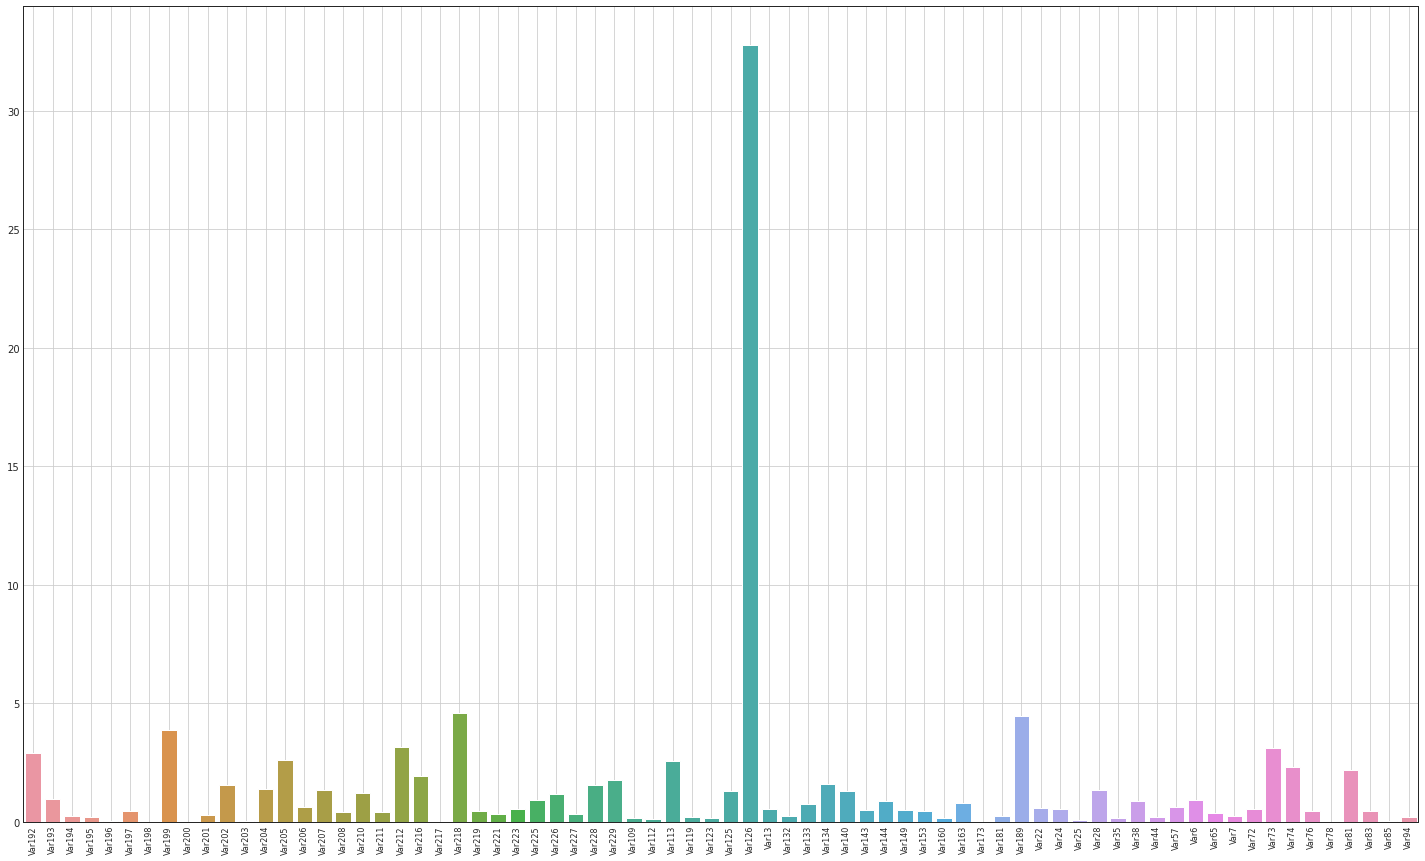

In [20]:
plot_barplot(x=X_train.columns, y=model.feature_importances_, figsize=(25, 15))

In [21]:
selected = X_train.columns[model.feature_importances_ != 0]
selected

Index(['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var199',
       'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var218', 'Var219',
       'Var221', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229',
       'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126',
       'Var13', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144',
       'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var189',
       'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57',
       'Var6', 'Var65', 'Var7', 'Var72', 'Var73', 'Var74', 'Var76', 'Var81',
       'Var83', 'Var85', 'Var94'],
      dtype='object')

In [22]:
# скорректируем имеющиеся списки числовых и категориальных признаков
numerical, categorical = correct_features_lists(selected, numerical, categorical)

After correction: numerical - 40 , categorical: -  28 



In [23]:
# зададим определенный порядок переменных
train = train[categorical + numerical + ['target']]
test = test[categorical + numerical]

In [24]:
# сохраним обработанные данные, а также списки переменных
train.to_csv('../data/intermediate/train.csv')
test.to_csv('../data/intermediate/test.csv')
np.save('../data/intermediate/numerical.npy', numerical)
np.save('../data/intermediate/categorical.npy', categorical)